In [1]:
#import netgen.gui
from ngsolve import *
from netgen.geom2d import SplineGeometry
from math import pi
import matplotlib.pyplot as plt
import numpy as np

In [12]:
geo = SplineGeometry()
geo.AddRectangle((-1,-1),(1,1),bc=1)
mesh = Mesh( geo.GenerateMesh(maxh=0.5))

V = H1(mesh, order=3, dirichlet=[1])
# finite element space and gridfunction to represent the heatflux:
space_flux = HDiv(mesh, order=2)
gf_flux = GridFunction(space_flux, "flux")

u = V.TrialFunction()
v = V.TestFunction()

r = sqrt(x*x+y*y)
r2 = x*x+y*y
R = 1/2

alpha = IfPos(r-R,2*log(1/R),1)

solution = IfPos(r-R,1.0/16.0*log(r2)/log(R*R),1.0/8.0-r2/4.0)
sol_flux = alpha * IfPos(r-R,1.0/16.0/log(R*R)*
                     CoefficientFunction((2*x/r2,2*y/r2)),
                     CoefficientFunction((-x/2.0,-y/2.0)))
rhs = IfPos(r-R,0,1)

In [13]:
a = BilinearForm(V, symmetric=False)
a += SymbolicBFI(alpha*grad(u)*grad(v))

f = LinearForm(V)
f += SymbolicLFI(rhs*v)

gfu = GridFunction(V)
flux = alpha * grad(gfu)
#gf_flux.Set(flux)
Draw (gfu,mesh,"u")
Draw (grad(gfu),mesh,"grad_u")

In [14]:
def SolveBVP():
    V.Update()
    gfu.Update()
    
    space_flux.Update()
    gf_flux.Update()
    
    a.Assemble()
    f.Assemble()
    gfu.Set(solution)
    f.vec.data -= a.mat * gfu.vec
    gfu.vec.data += a.mat.Inverse(V.FreeDofs(),"umfpack") * f.vec
    Redraw (blocking=True)

In [15]:
def CalcError():
    space_flux.Update()
    gf_flux.Update()
    # interpolate finite element flux into H(div) space:
    gf_flux.Set (flux)
    # compute error on every element:
    err = 1/alpha*(flux - sol_flux)*(flux - sol_flux)
    elerr = Integrate (err, mesh, VOL, element_wise=True)
    
    # sort elements (corresponding to error contribution)
    err_and_el_sorted = sorted([(entry,i) for i, entry in enumerate(elerr)], key= lambda x:-x[0])
    # reset marks
    marks = [False for el in mesh.Elements()]

    # mark element with largest error until 10% of the error is on marked elements:
    sumerr = sum(elerr)    
    accsum = 0
    for err,el in err_and_el_sorted:
        if accsum < 0.1 * sumerr:
            marks[el] = True
            accsum += err
        else:
            break
    
    print ("V.ndof = ", V.ndof)
    H1error = sqrt(Integrate (1/alpha*(flux - sol_flux)*(flux - sol_flux), mesh, VOL))
    print ("weighted H1 (semi norm) error = ", H1error)
    L2error = sqrt(Integrate ((gfu - solution)*(gfu - solution), mesh, VOL))
    print ("hier L2 error = ", L2error)
    
        # call the refinement according to the marks:
    for el in mesh.Elements():
        mesh.SetRefinementFlag(el, marks[el.nr])
    return  L2error,V.ndof,sumerr

In [16]:
with TaskManager():
    L2error_2 = []
    H1error_2 = []
    d_2 = []
    #L2error_2 = []
    #d_2 = []
    while V.ndof < 10000:  
        SolveBVP()
        temp,d,H1flux = CalcError()
        L2error_2.append(temp)
        H1error_2.append(H1flux)
        d_2.append(d)
        mesh.Refine()
    SolveBVP()

V.ndof =  187
weighted H1 (semi norm) error =  0.024959054259342965
hier L2 error =  0.002462722808148027
V.ndof =  223
weighted H1 (semi norm) error =  0.022888471449799105
hier L2 error =  0.0026794152296791534
V.ndof =  277
weighted H1 (semi norm) error =  0.018998143874695613
hier L2 error =  0.0010821887077441395
V.ndof =  349
weighted H1 (semi norm) error =  0.017664852668943392
hier L2 error =  0.0008283449671201662
V.ndof =  394
weighted H1 (semi norm) error =  0.017383427823566028
hier L2 error =  0.0009115381432693107
V.ndof =  439
weighted H1 (semi norm) error =  0.01602484983446081
hier L2 error =  0.0006837596810957443
V.ndof =  547
weighted H1 (semi norm) error =  0.014210889637124633
hier L2 error =  0.0005123112180938968
V.ndof =  637
weighted H1 (semi norm) error =  0.013189342915648208
hier L2 error =  0.0003579056434196425
V.ndof =  700
weighted H1 (semi norm) error =  0.012877023723206893
hier L2 error =  0.0005079172702962653
V.ndof =  790
weighted H1 (semi norm) e

In [21]:
L2error_2
H1error_2

[0.0006229543895208262,
 0.0005238821253082687,
 0.0003609294706836345,
 0.0003120470198154765,
 0.0003021835628971294,
 0.00025679581221701867,
 0.0002019493842785363,
 0.0001739587665465596,
 0.0001658177399680331,
 0.00014215983256819745,
 0.00012660591671252185,
 0.00010577201636966229,
 9.64001156779723e-05,
 8.998503422675092e-05,
 8.003868091817458e-05,
 7.179778754472066e-05,
 6.43693599210683e-05,
 5.806442110007667e-05,
 5.542793895218405e-05,
 5.044271782523442e-05,
 4.8014609594472616e-05,
 4.4422486773485305e-05,
 3.98805372169515e-05,
 3.782210383897499e-05,
 3.3551482526370176e-05,
 3.181020103291087e-05,
 2.965662265847082e-05,
 2.6324567629603176e-05,
 2.4733320689543163e-05,
 2.357101383804127e-05,
 2.1974191583804753e-05,
 2.0423876061827385e-05,
 1.8455406834433826e-05,
 1.7274351959789168e-05,
 1.601896500391122e-05,
 1.4654781318818153e-05,
 1.3328284086060538e-05]

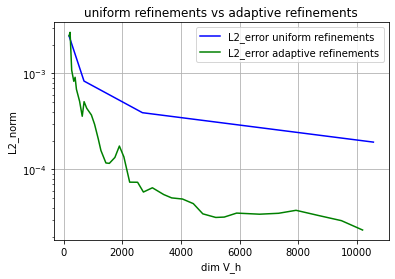

In [40]:
plt.figure()
plt.title("uniform refinements vs adaptive refinements")
plt.grid()
plt.semilogy(d_1,L2error_1,'b',label='L2_error uniform refinements')
plt.semilogy(d_2,L2error_2,'g',label='L2_error adaptive refinements')
#plt.semilogy(d_1,H1error_1)
#plt.semilogy(d_2,H1error_2)
plt.xlabel("dim V_h")
plt.ylabel("L2_norm")
plt.legend()
plt.savefig('uniform refinements vs adaptive refinements')

### explenation
The blue line represents the error with the uniform refinments. That means the mesh is uniformt over the hole domain. The other line th error from the adaptive one. The algorytmus measures the error and define the new grid in the "critical area". It lies on the boundary on the circuit with an radius of $R$.

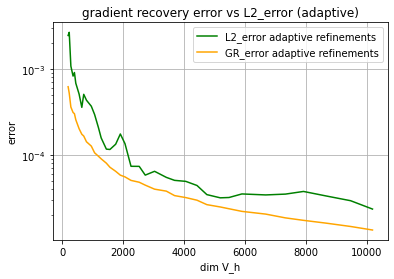

In [41]:
plt.figure()
plt.title("gradient recovery error vs L2_error (adaptive)")
plt.grid()
#plt.semilogy(d_1,L2error_1)
plt.semilogy(d_2,L2error_2,'g',label='L2_error adaptive refinements')
plt.semilogy(d_2,H1error_2,color='orange',label='GR_error adaptive refinements')
plt.xlabel("dim V_h")
plt.ylabel("error")
plt.legend()
plt.savefig('gradient recovery error vs L2_error (adaptive)')

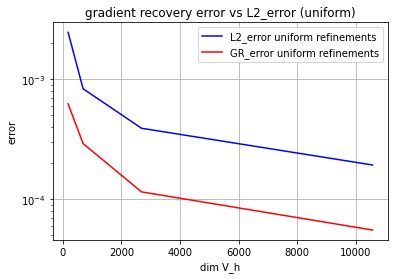

In [42]:
plt.figure()
plt.title("gradient recovery error vs L2_error (uniform)")
plt.grid()
#plt.semilogy(d_1,L2error_1)
plt.semilogy(d_1,L2error_1,'b',label='L2_error uniform refinements')
plt.semilogy(d_1,H1error_1,color='red',label='GR_error uniform refinements')
plt.xlabel("dim V_h")
plt.ylabel("error")
plt.legend()
plt.savefig('gradient recovery error vs L2_error (uniform)')